# Filtering marker gene datasets

Here, we'll walk through some filtering strategies applicable to compositional marker gene studies. We will employ several custom R scripts designed to manipulate phyloseq-class datasets that aid in the filtering and reproducability of marker gene studies. We apply this workflow to a subset of a larger 16S community dataset, though these scripts are scalable to any marker gene and large datasets with thousands of taxa and samples. 

<div class="alert alert-block alert-info">
<b>A preface on filtering:</b> Filtering is an <i>essential</i> step in the analyis of marker gene datasets. This workflow uses a two-pronged approach to filtering contaminants from read datasets. That is, we attempt to remove two types of contamination: <br>
<br>
1. Real biological sequences that have cross contaminated unassociated samples. <br>
<br>
2. Exogenous contaminants introduced during sample preparation. <br>
<br>
To achieve this, we'll first filter out taxa below an abundance threshold individually within each sample. We estimate this threshold empirically by measuring the number of amplicon sequence variants (ASVs) within known mock communities under various thresholds and select the threshold that returns the desired results. Next, we'll remove control samples from the dataset and then apply a dataset-wide prevalence filter to remove exogenous contaminants present as low abundance ASVs. 
</div>

***

## Before we begin...
This workflow assumes that your sequencing project has been:
-  processed with __[dada2](https://benjjneb.github.io/dada2/index.html)__ (namely, that your ASV names are the ASV nucleotide sequences)
-  converted into a __[phyloseq](https://joey711.github.io/phyloseq/)__ object

In [1]:
library(RCurl); packageVersion("RCurl")

Loading required package: bitops


[1] ‘1.95.4.10’

In [2]:
library(phyloseq); packageVersion("phyloseq")

[1] ‘1.19.1’

In [3]:
library(ggplot2); packageVersion("ggplot2")
theme_set(theme_bw()) #gray sucks

[1] ‘2.2.1’

## Getting started
First, we'll need to source the functions into our R environment. We can do that directly from Github with some handy functions provided by HW. 

In [4]:
load("/Users/bpb/Desktop/marker_gene_filtering_functions/marker_gene_processing_vignette/nigerian.dada2.RData")
NI <- nd2
library(devtools); packageVersion("devtools")
mylink <- "https://github.com/itsmisterbrown/marker_gene_processing_scrips/raw/master/marker_gene_processing_functions.R"
source_url(mylink) #compliments of Hadley

[1] ‘1.13.6’

SHA-1 hash of file is 1e2dc1f20fa49ebb0635850acf0431ed5cac33bf


For this vignette, we'll work with a subset of a recent study of stool samples from Nigerian infants. Let's take a look at the raw dataset

In [5]:
NI

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2195 taxa and 149 samples ]
sample_data() Sample Data:       [ 149 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2195 taxa by 7 taxonomic ranks ]

Our unfiltered object has 2,195 taxa (that's a lot!), though some of those bugs are likely contaminants or irrelevent stochastic associates. We'll use some filtering functions to pare that number down to a smaller set of  bugs that we can interrogate with downstream analyses. First, we'll estimate the threshold at which our data suggest cross contamination persists. We can do this with the __estimate.threshold()__ function.

In [6]:
(ws.threshold <- estimate.threshold(ps = NI, WSmin = 1e-4, WSmax = 2e-4, WSstep = 1e-5, controlID = "pc1"))

control.taxa.count,read.count,read.percent,threshold.value
23,89567283,99.80368,0.00010
23,89553735,99.78859,0.00011
23,89541319,99.77475,0.00012
23,89527748,99.75963,0.00013
23,89513016,99.74321,0.00014
23,89500419,99.72918,0.00015
22,89487204,99.71445,0.00016
22,89472732,99.69833,0.00017
22,89460411,99.68460,0.00018
22,89449162,99.67206,0.00019


And let's take a peek at a quick visual summary

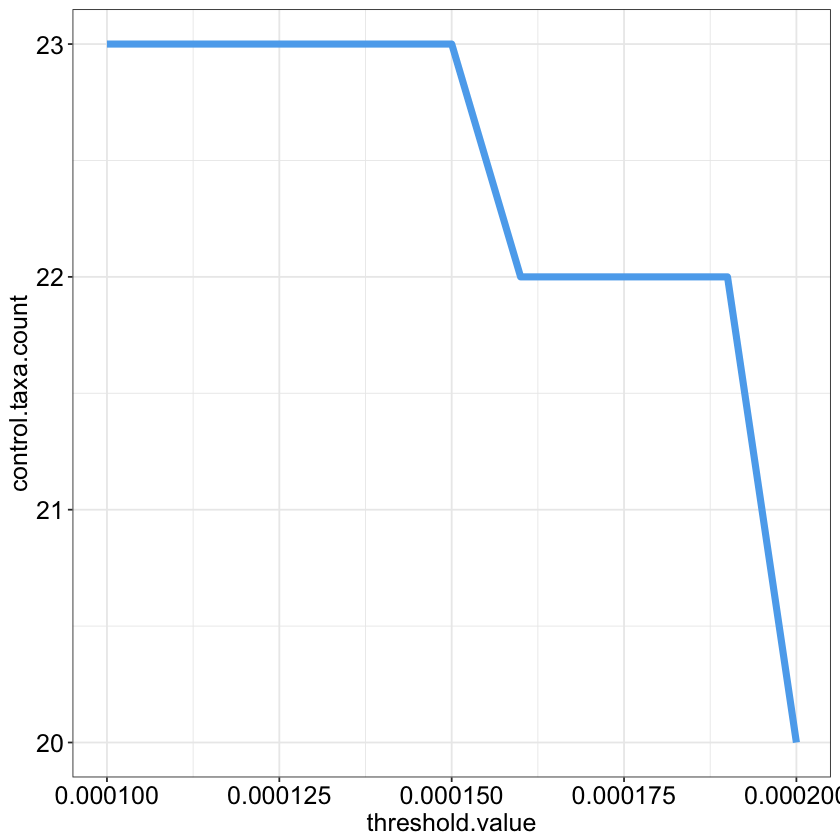

In [7]:
ggplot(data = ws.threshold, aes(x = threshold.value, y = control.taxa.count)) + geom_line(size=2, color="steelblue2") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 15, colour = "black"),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black"))


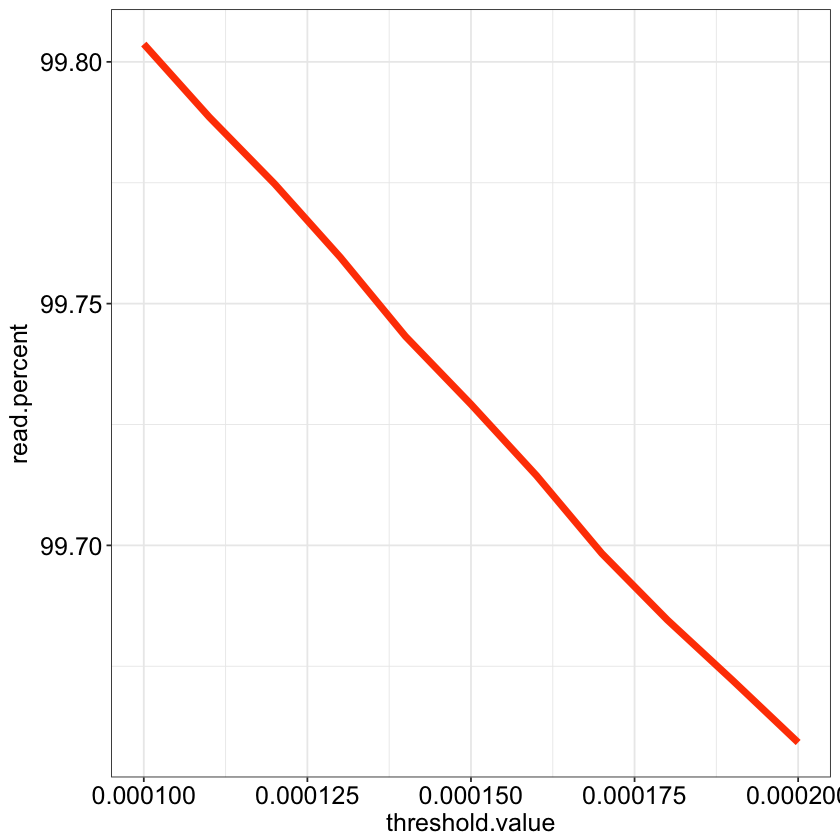

In [8]:
ggplot(data = ws.threshold, aes(x = threshold.value, y = read.percent)) + geom_line(size=2, color="orangered1") + 
  theme(axis.text.y = element_text(size = 15, colour = "black"),
        axis.text.x = element_text(size = 15, colour = "black"),
        axis.title.x = element_text(size = 15, colour = "black"),
        axis.title.y = element_text(size = 15, colour = "black"))


***
It looks like a within-sample threshold of 2e-4 is sufficient for recovering the desired taxa count for our mock communities without sacrificing too many reads. Now that we've determined our threshold, let's apply this cutoff to our dataset with the __filter.dataset()__ function.

<div class="alert alert-block alert-info">
The <b>filter.dataset()</b> function does what its name suggests, along with a few other handy options. It applies both within-sample (WS) and prevalence (P) filters to the dataset, and removes any control samples (or any that match the metadata identifier given). <br>
<br>
<b>Output is as follows:</b> <br>
<b>control.taxa.sequences</b>
-  These are the nucleotide sequences of the taxa remaining in the positive control after applying the within-sample filter threshold.  <br>
<br>
<b>taxonomy.of.control.taxa</b>
-   The taxonomy of taxa in the positive control are output in the same order as the sequences, above. Generally useful for validating that the bugs detected in your mock community are as intended. <br>
<br>
<b>read.count.table</b>
-  This table lists the read count and percentage remaining after each filtering step. Control samples are removed after the WS filter and before the P filter and, as such, will list NA values for the prevalence filter statistics.  <br>
<br>
<b>prevalence.filter.threshold</b>
-  The read count corresponding to the percentage given to the P parameter. <br>
<br>
<b>filtered.phyloseq</b>
-  the shiny new (phyloseq class) filtered dataset with control samples removed. <br>
<br>

</div>


In [9]:
NI.f <- filter.dataset(ps = NI, controlID = "pc1", controlCAT = "timepoint", 
                      controlFACTOR = "control", WSF = 2e-4, PF = 1e-5, return.all = TRUE)

In [10]:
NI.f$control.taxa.sequences

[1] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACAGAACTTTCCAGAGATGGATTGGTGCCTTCGGGAACTGTGAGACAGG"
 [2] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACGGAAGTTTTCAGAGATGAGAATGTGCCTTCGGGAACCGTGAGACAGG"
 [3] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTTTGACAACTCTAGAGATAGAGCCTTCCCCTTCGGGGGACAAAGTGACA"
 [4] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTCTGACCCCTCTAGAGATAGAGTTTTCCCCTTCGGGGGACAGAGTGACA"
 [5] "GGACCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAAATCTTGACATCCTTTGACAACTCTAGAGATAGAGCTTTCCCCTTCGGGGGACAAAGTGACA"
 [6] "GGGCCCGCACAAGCGGCGGAGCATGCGGATTAATTCGATGCAACGCGAAGAACCTTACCAAGGCTTGACATGCACGGCGGCACTGCAGAGATGTGGTGGCATTTAGTTGGTCGTGTGCAGGT"
 [7] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCCGATGCTATTCTTAGAGATAGGAAGTTACTTCGGTACATCGGAGACAGG"
 [8] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGCCTTGACATCCAATGAACTTTCTAGAGATAGATTGGTGCCTTCGGGAACATTGAGACAGG"
 [9] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGCAGAACCTTACCAACCCTTGACATGGCGATCGCGGTTCCAGAGATGGTTCCTTCAGTTCGGCTGGATCGCACACA"
[10] "GGGCCCGCACAAGCGGAGGAACATGTGGTTTAATTCGATGATACGCGAGGAACCTTACCCGGGCTTAAATTGCAGATGAATTACGGTGAAAGCCGTAAGCCGCAAGGCATCTGTGAAGGTGC"
[11] "GGACCCGCACAAGCGGTGGATGATGTGGATTAATTCGATGCAACGCGAAAAACCTTACCTACCCTTGACATGTCTGGAATGCCGAAGAGATTTGGTAGTGCTCGCAAGAGAACCGGAACACA"
[12] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCAGTGCAAACCTAAGAGATTAGGTGTTCCCTTCGGGGACGCTGAGACAGG"
[13] "GGCCCCGCACAAGCGGCGGAGCATGCGGATTAATTCGATGCAACGCGTAGAACCTTACCTGGGTTTGACATGGATCGGGAGTGCTCAGAGATGGGTGTGCCTCTTTTGGGGTCGGTTCACAG"
[14] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTCTGACAACCCTAGAGATAGGGCTTCTCCTTCGGGAGCAGAGTGACAGG"
[15] "GGGCCCGCACAAGCAGCGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCTAGACTTGACATCTCCTGAATTACCCTTAATCGGGGAAGCCCTTCGGGGCAGGAAGACAGGTG"
[16] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCTGGCCTTGACATGCTGAGAACTTTCCAGAGATGGATTGGTGCCTTCGGGAACTCAGACACAGG"
[17] "GGACCCGCACAAGCGGTGGATGATGTGGATTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATGTACGGAATCCTCCGGAGACGGAGGAGTGCCTTCGGGAGCCGTAACACAGG"
[18] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATCCTTTGACCACTCTGGAGACAGAGCTTTCCCTTCGGGGACAAAGTGACAGG"
[19] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGCCTTGACATACTAGAAACTTTCCAGAGATGGATTGGTGCCTTCGGGAATCTAGATACAGG"
[20] "GGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGAAGCAACGCGAAGAACCTTACCAGGTCTTGACATGCTAGGAACTTTGCAGAGATGCAGAGGTGCCCTTCGGGGAACCTAGACACA"

In [11]:
NI.f$taxonomy.of.control.taxa

Kingdom,Phylum,Class,Order,Family,Genus,Species
Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Salmonella,NA
Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Escherichia/Shigella,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,NA
Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,lingnae/odontolyticus/turicensis
Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,mutans
Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,NA
Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Rhodobacter,azotoformans/johrii/megalophilus/sphaeroides
Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,vulgatus


In [12]:
NI.f$read.count.table[142:149, ]

,unfiltered.read.count,WSfiltered.read.count,WSfiltered.read.percent,Pfiltered.read.count,Pfiltered.read.percent
N.0705..Week.15,1163553,1157414,99.47239,1156481,99.39221
N.0705..Week.4,934760,930529,99.54737,930529,99.54737
nc1,109438,108053,98.73444,NA,NA
nc2,9943,9943,100.00000,NA,NA
nc3,177463,175363,98.81665,NA,NA
nc4,15991,15971,99.87493,NA,NA
nc5,37114,36837,99.25365,NA,NA
pc1,697410,696690,99.89676,NA,NA


In [13]:
NI.f$prevalence.filter.threshold

[1] 883.9479

In [14]:
(NIF <- NI.f$filtered.phyloseq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 347 taxa and 143 samples ]
sample_data() Sample Data:       [ 143 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 347 taxa by 7 taxonomic ranks ]

Next, we'll export all of the data associated with our final, filtered dataset using the __write.dataset()__ function. Unfortunately, I've never been able to get the biomformat package (v1.2.0) to play nice with my version of phyloseq, but y'all may have more luck with newer versions. In case the kinks have been worked out, I'd recommend using the __write.dataset.biom()__ function to export your dataset directly to biom format. Until then, we'll use __write.dataset()__ to perform some final minor modifications and export our dataset.

<div class="alert alert-block alert-info">
Prior to writing output, both functions rename all taxa as ASV1, ASV2, ..., ASVN, for ease of visualization and handling in downstream analysis.<br>
<br>
<b>Output:</b> The output of these scripts are as follows: <br>
<br>
<b>Both:</b>
-  FASTA of all ASV sequences. dada2 does not assign names to each ASV, but rather uses the nucleotide sequence as the identifier; we can leverage this feature to write an output in FASTA format of each ASV before we assign names.  <br>
<br>
<b>write.dataset.biom():</b>
-   A biom file with observation and sample metadata integrated. I've run into problems attempting to import the resulting biom back into phyloseq, but this might warrant a closer look with a newer version. <br>
<br>
<b>write.dataset():</b>
-  A standard count table (eg. OTU table) of read counts of taxa (ASVs) within each sample. <br>
-  A taxonomy table with the sequence identifier (eg. ASV1) in the first column and semicolon-separated taxonomy in the second column.<br>
-  A sample data table of all associated metadata. 
<br>

</div>
<br>
<div class="alert alert-block alert-success">
Before writing, all files written by <b>write.dataset()</b> are formatted for easy merging into a biom file using the  <A HREF = "http://biom-format.org/documentation/biom_conversion.html">standalone biom package</A> without any further manipulation. 
</div>

In [15]:
fp <- paste(getwd(), "/", sep = "")
NIF.f <- write.dataset(ps = NIF, filepath = fp, fileprefix = "Nif.f")

[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_ASVs.fasta"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_ASV_table.txt"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_ASV_taxonomy.txt"
[1] "/Users/bpb/Desktop/marker_gene_filtering_functions/Nif.f_sample_data.txt"


In [16]:
phyloseq::otu_table(NIF.f)[1:10, 1:10]

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10
N.0055..baseline,0,57092,0,0,0,0,532461,8519,0,55386
N.0055..Week.15,3137,50,126,170,12,16,59,26,27,0
N.0055..Week.36,1745,583068,295,7571,0,0,0,225,161094,0
N.0055..Week.4,1552,4311,24642,3267,422,0,0,104530,0,1295
N.0170..baseline,1438,368,362,772,431,392,1023,361,265,1382
N.0170.Week.15,136177,269,99767,0,642,505,1201,72,3606,91
N.0170.Week.36,367401,8053,17969,0,40399,31963,271,0,50041,752
N.0170.Week.4,335868,788,77043,0,11923,6800,1818,42446,4513,0
N.0183..baseline,12981,5611,44012,1452,1553,1915,1577,1821,231,2531
N.0183.Week.15,58948,97,23709,0,111,0,0,56,2227,0
